In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import numpy.matlib
import theano.tensor as tt

from sklearn import preprocessing
from theano import shared
from scipy.special import expit as logistic
from scipy.special import softmax
from scipy.stats import betabinom

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
RANDOM_SEED = 42
np.random.seed(42)

In [4]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.8.2
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 13 Models With Memory

**Multilevel Models** remember features of each cluster in the data as they learn about all of the clusters. Depending upon the variation among clusters, which is learned from the data as well, the model pools information across clusters. This pooling tends to improve estimates about each cluster. 

Multilevel models go by many different names, and some statisticians use the same names for different specialized variants, while others use them all inter- changeably. The most common synonyms for “multilevel” are **hierarchical** and **mixed effects**. The type of parameters that appear in multilevel models are most commonly known as random effects, which itself can mean very different things to different analysts and in different contexts.186 And even the innocent term “level” can mean different things to different people. There’s really no cure for this swamp of vocabulary aside from demanding a mathematical or algorithmic definition of the model. Otherwise, there will always be ambiguity.

## 13.1. Example: Multilevel tadpoles

### Code 13.1

In [6]:
# load data
df = pd.read_csv('Data/reedfrogs.csv', sep=',')
print(df.shape)
df.head()

(48, 5)


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


A multilevel model, in which we simultaneously estimate both an intercept for each tank and the variation among tanks, is what we want. This will be a **varying intercepts** model. Varying intercepts are the simplest kind of **varying effects**.

### Code 13.2

In [7]:
# generate tank ID
df['tank'] = range(len(df))

In [8]:
# define model: mortality ~ tank
with pm.Model() as m13_1:
    
    a = pm.Normal('a', mu=0, sd=1.5, shape=df['tank'].max()+1)
    
    pbar = pm.Deterministic('pbar', pm.math.invlogit(a[df['tank'].values]))
                      
    S = pm.Binomial('S', p=pbar, n=df['density'].values, observed=df['surv'].values)

    trace_m13_1 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3460.84draws/s]


In [9]:
# show model summary
varnames = ['~pbar']
az.summary(trace_m13_1, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.71,0.77,0.54,2.95
a[1],2.43,0.94,0.93,3.87
a[2],0.76,0.63,-0.25,1.77
a[3],2.38,0.86,1.00,3.73
a[4],1.70,0.76,0.45,2.84
a[5],1.73,0.77,0.48,2.91
a[6],2.40,0.90,0.98,3.78
a[7],1.72,0.76,0.50,2.90
a[8],-0.37,0.63,-1.39,0.61
a[9],1.72,0.78,0.53,2.95


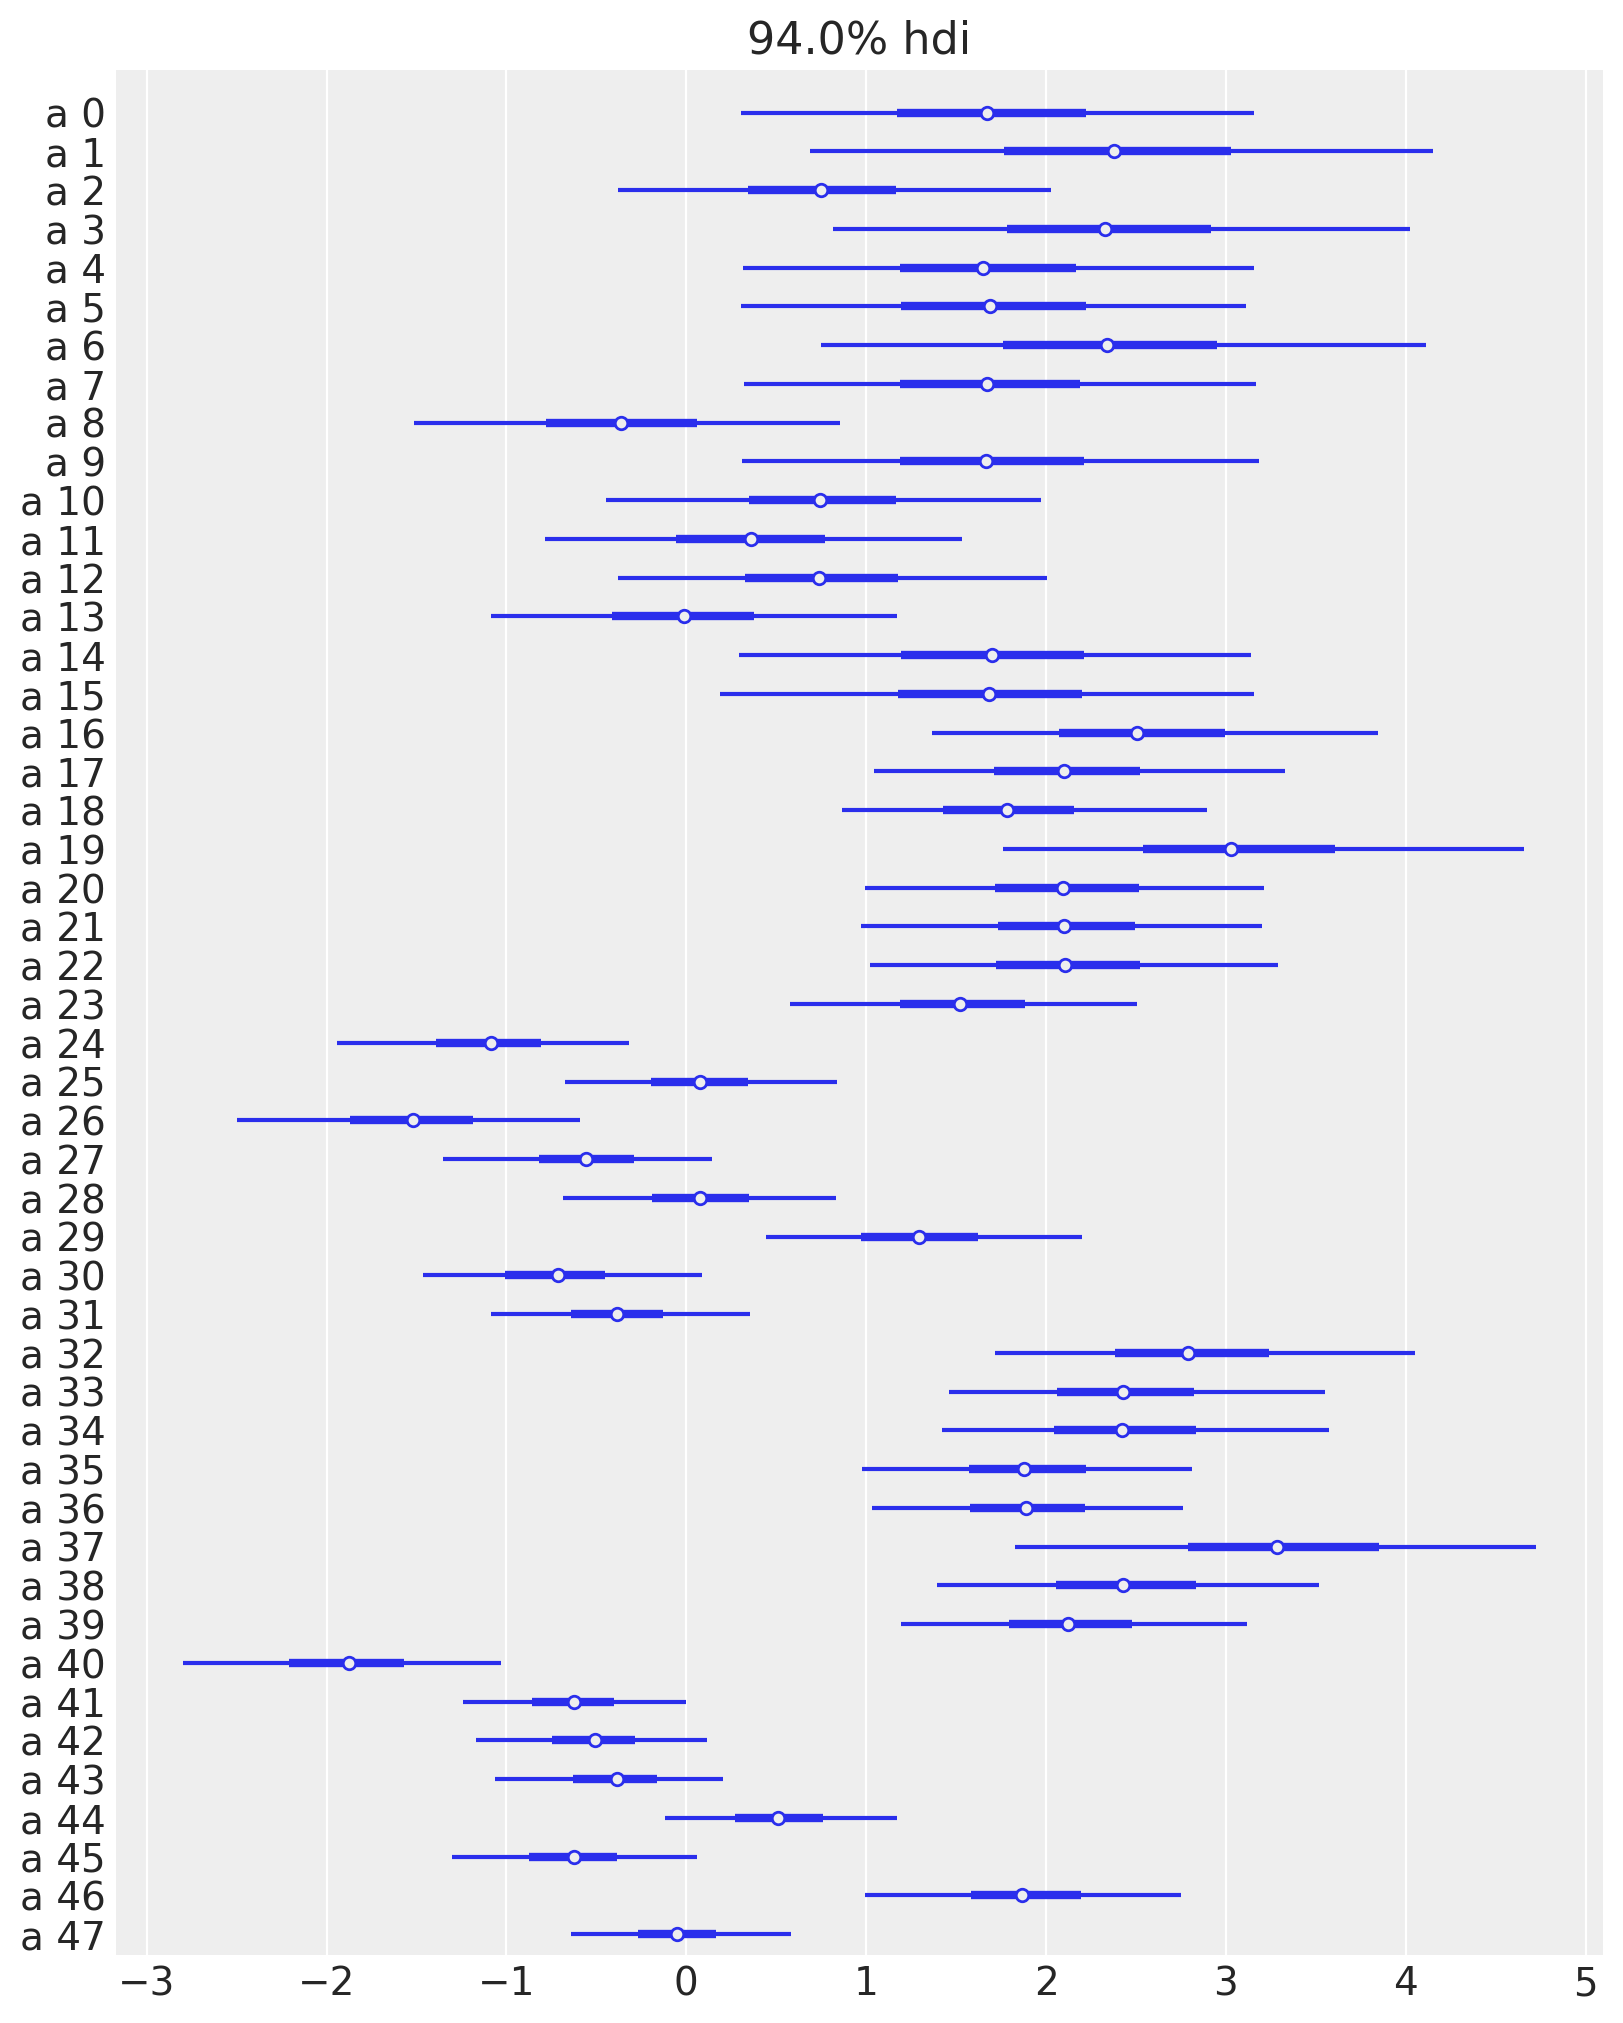

In [10]:
# plot results
axes = az.plot_forest(
    trace_m13_1,
    kind='forestplot',
    var_names=['a'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.94,
    figsize=(8, 10))

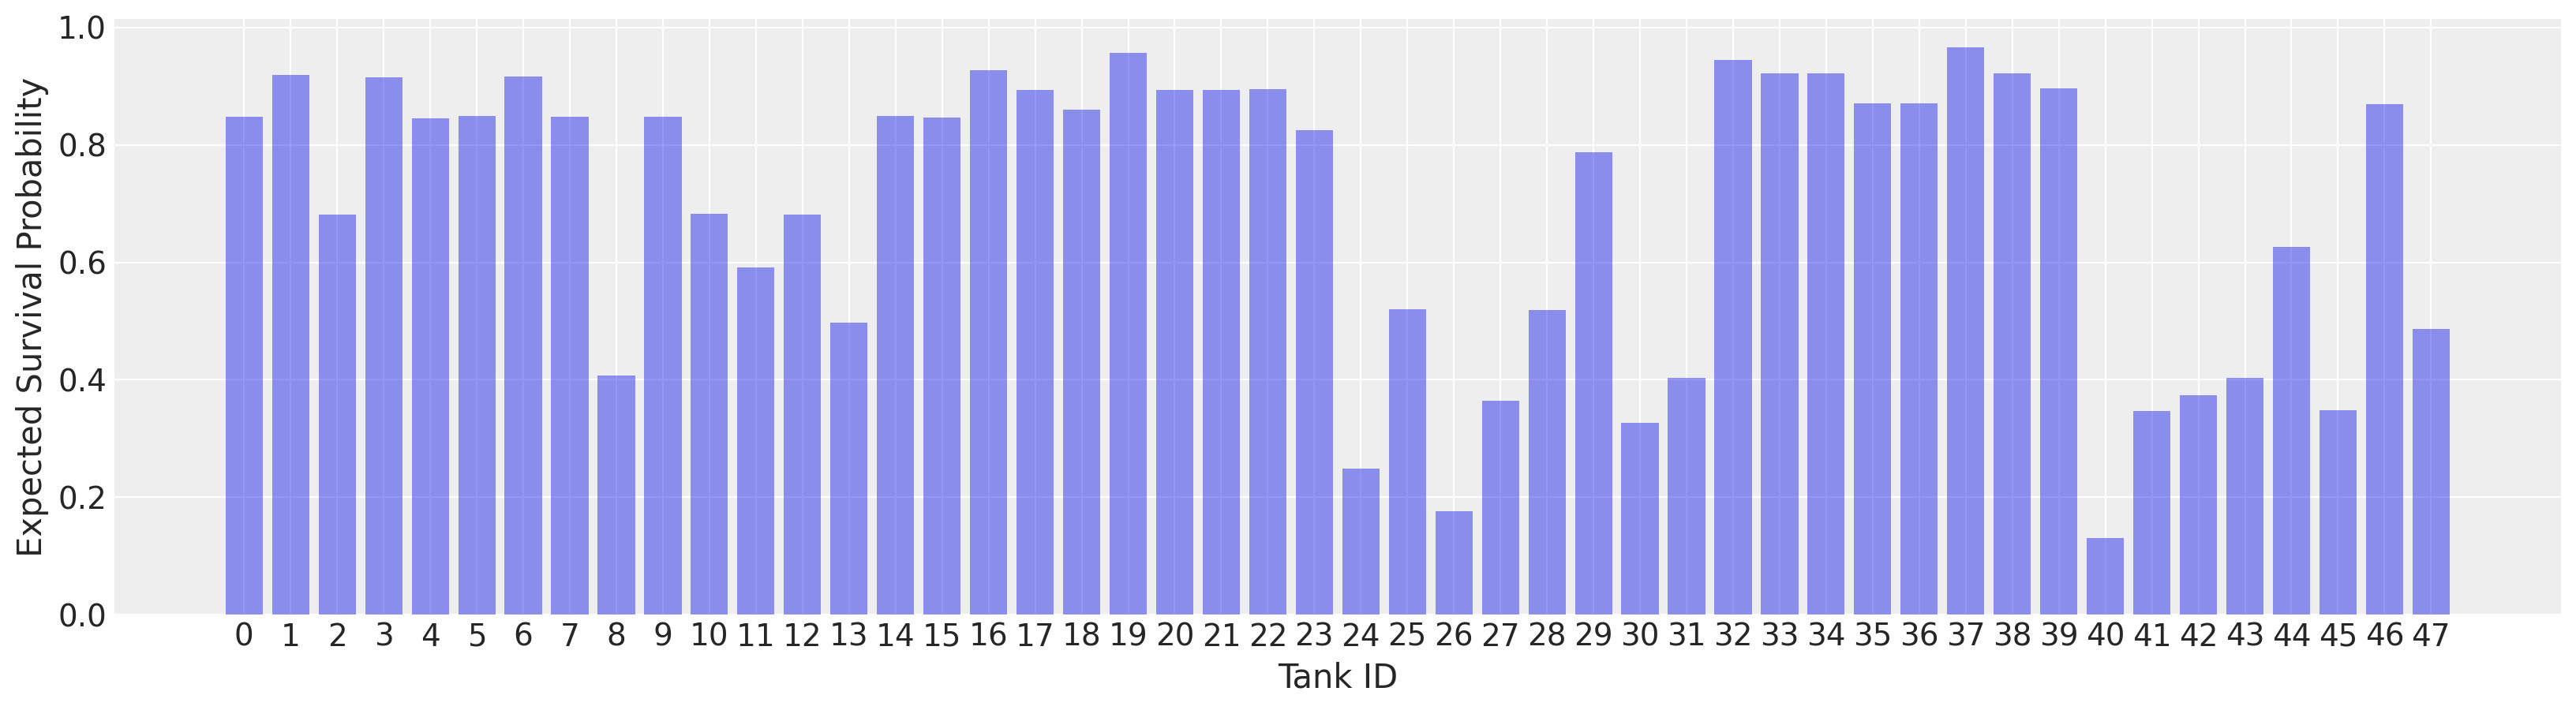

In [11]:
# plot expected survival probability
fig = plt.figure(figsize=(20, 5))
plt.bar(range(len(df)), logistic(trace_m13_1['a'].mean(0)),  alpha=0.5)
plt.ylabel('Expected Survival Probability', fontsize=15)
plt.xlabel('Tank ID', fontsize=15)
plt.xticks(range(len(df)))
plt.show()

These two parameters, $\bar{\alpha}$ and $\sigma$, are often referred to as **hyperparameters**. They are parameters for parameters. And their priors are often called **hyperpriors**.

### Code 13.3

In [12]:
# define model: mortality ~ tank (multi-level)
with pm.Model() as m13_2:
    
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', 1)
    
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=df['tank'].max()+1)
    
    pbar = pm.Deterministic('pbar', pm.math.invlogit(a[df['tank'].values]))
                      
    S = pm.Binomial('S', p=pbar, n=df['density'].values, observed=df['surv'].values)

    trace_m13_2 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2233.27draws/s]


In [13]:
# show model summary
varnames = ['~pbar']
az.summary(trace_m13_2, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a_bar,1.35,0.25,0.95,1.76
a[0],2.15,0.88,0.85,3.58
a[1],3.07,1.14,1.30,4.79
a[2],1.02,0.66,0.01,2.07
a[3],3.07,1.12,1.39,4.79
a[4],2.13,0.87,0.67,3.38
a[5],2.14,0.86,0.68,3.38
a[6],3.10,1.14,1.28,4.77
a[7],2.18,0.91,0.77,3.58
a[8],-0.18,0.60,-1.16,0.75


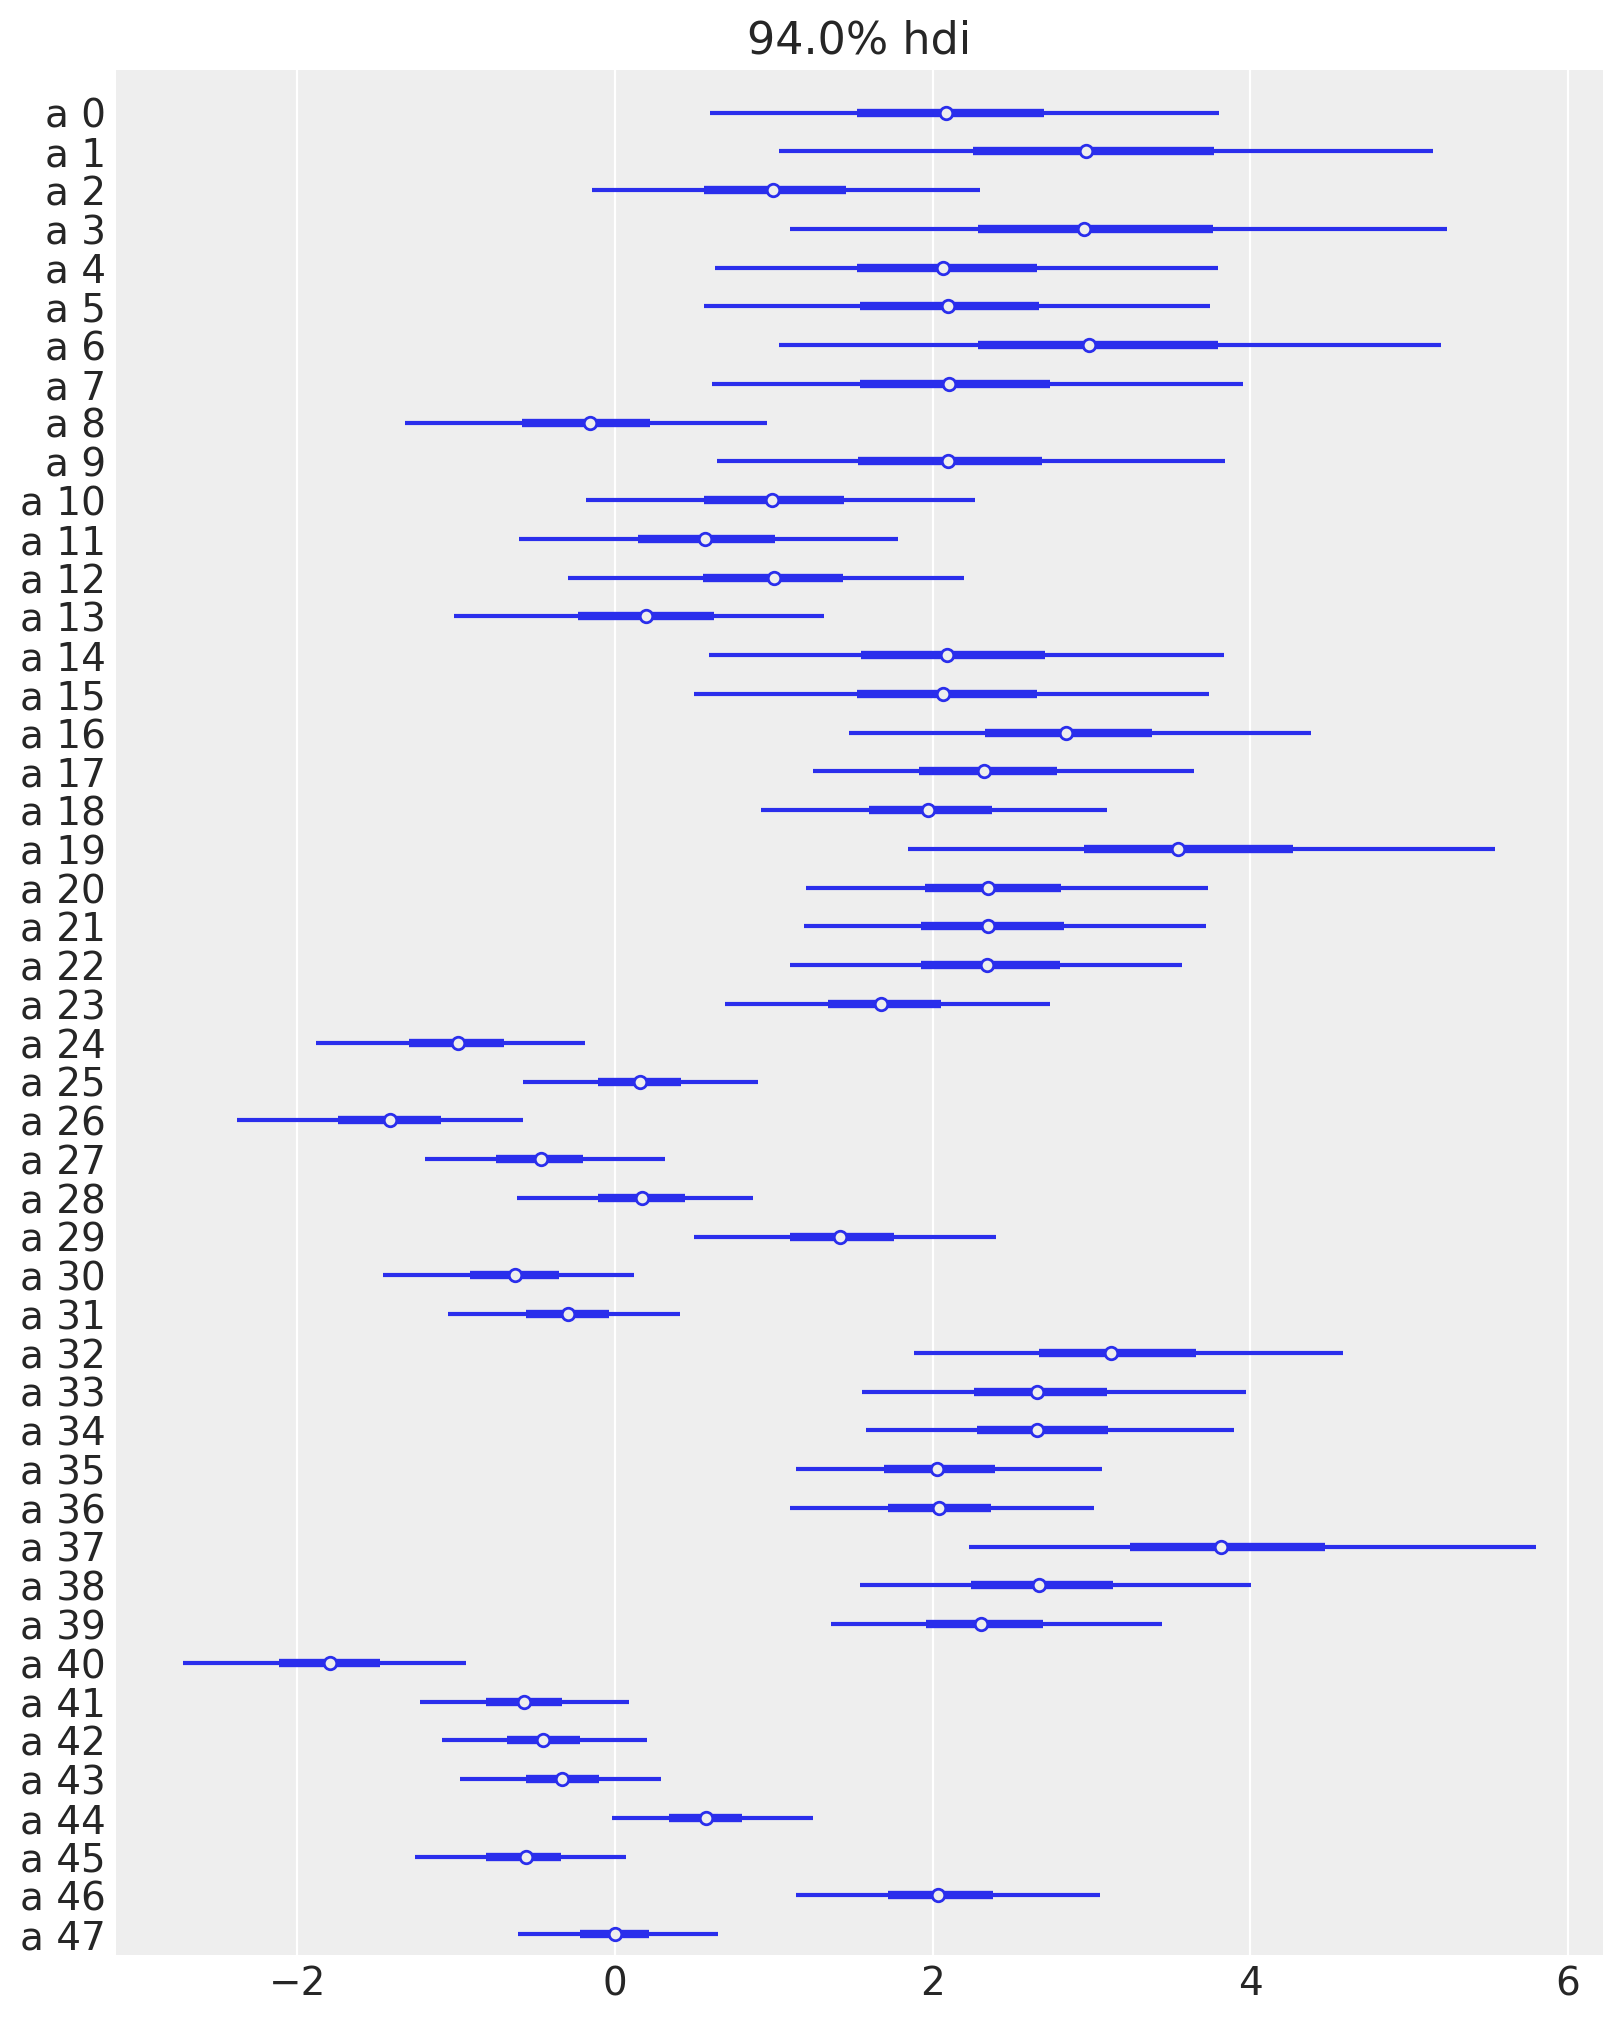

In [14]:
# plot results
axes = az.plot_forest(
    trace_m13_2,
    kind='forestplot',
    var_names=['a'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.94,
    figsize=(8, 10))

### Code 13.3

In [15]:
# model compare
pm.compare({'m13_1': trace_m13_1,
            'm13_2': trace_m13_2}, ic='WAIC', scale='deviance')

/Users/yifei-wang/.pyenv/versions/3.7.4/envs/Statistical_Rethinking/lib/python3.7/site-packages/arviz/stats/stats.py:1411: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13_2,0,200.339,21.0356,0,0.996824,4.54614,0,True,deviance
m13_1,1,214.645,25.6233,14.3059,0.00317588,7.12971,3.73619,True,deviance


### Code 13.5

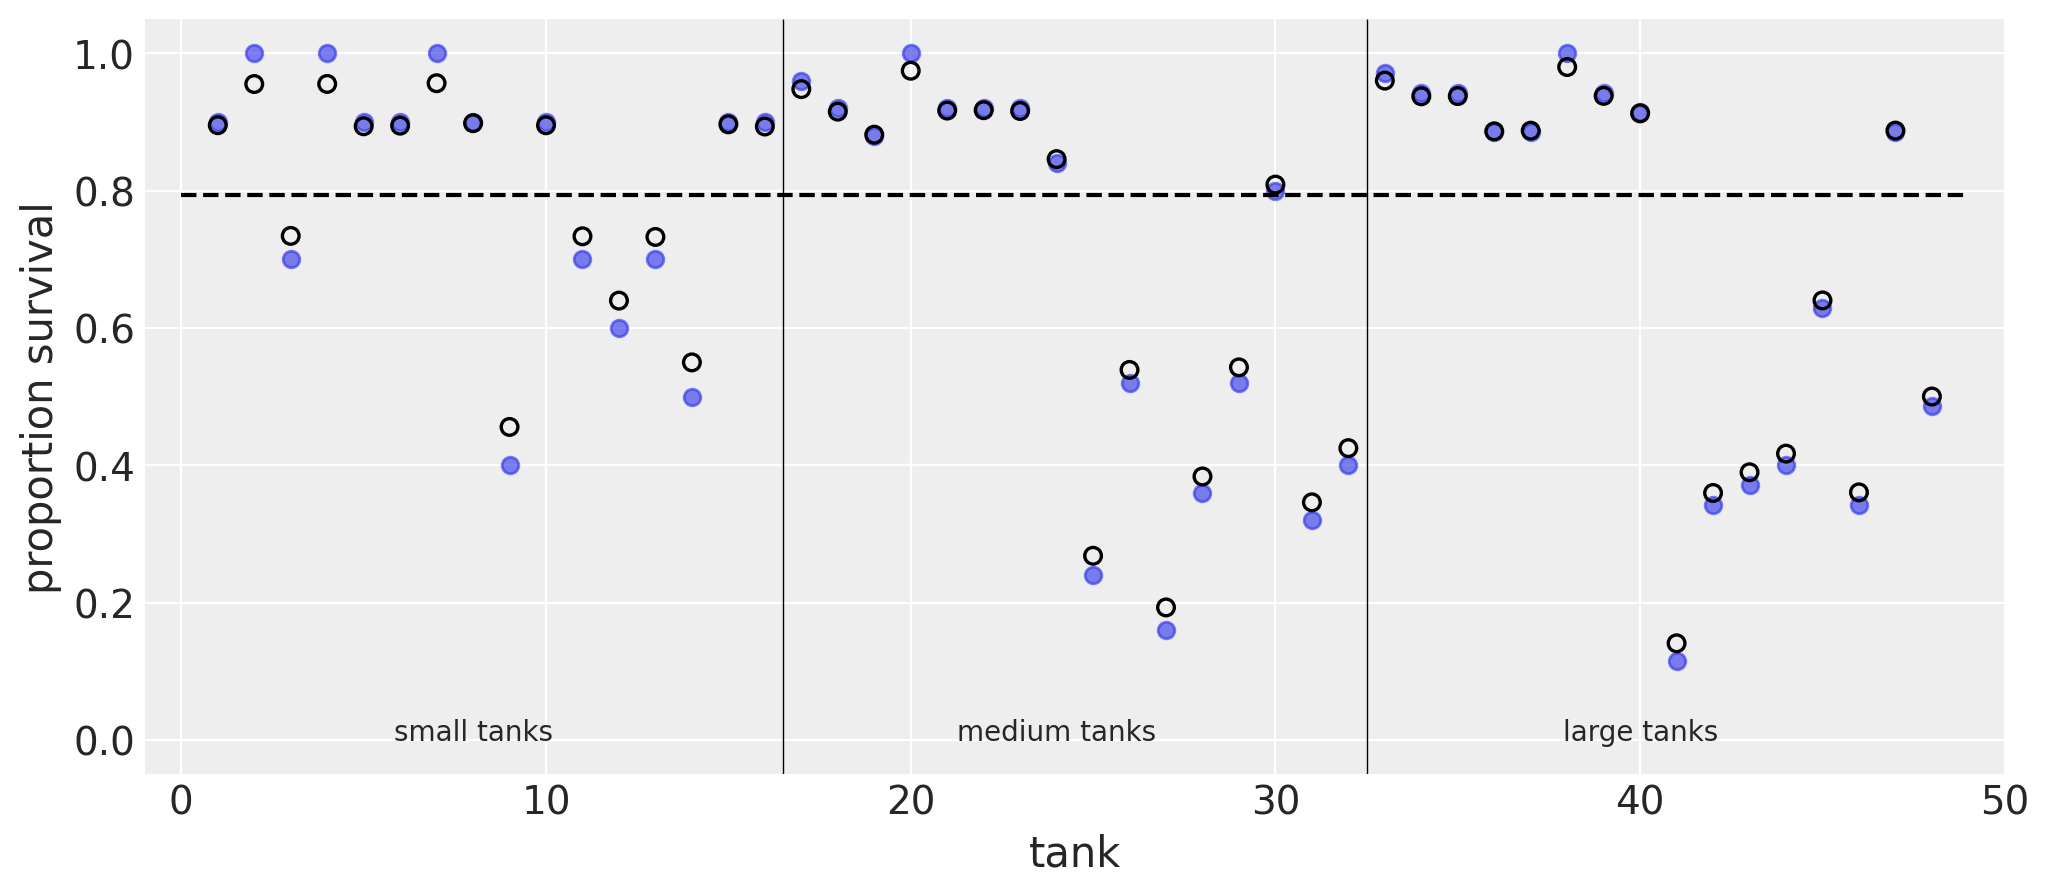

In [16]:

# compute mean intercept for each tank
# also transform to probability with logistic
propsurv_est = logistic(trace_m13_2['a'].mean(0))

_, ax = plt.subplots(1, 1, figsize=(12, 5))

# display raw proportions surviving in each tank
ax.scatter(np.arange(1, 49), df.propsurv, alpha=0.6)

# overlay posterior means
ax.scatter(np.arange(1, 49), propsurv_est, facecolors='none', edgecolors='k', lw=1.2)

# mark posterior mean probability across tanks
ax.hlines(logistic(trace_m13_2['a_bar'].mean()), 0, 49, linestyles="--")

# draw vertical dividers between tank densities
ax.vlines([16.5, 32.5], -0.05, 1.05, lw=0.5)
ax.text(8, 0, "small tanks", horizontalalignment="center")
ax.text(16 + 8, 0, "medium tanks", horizontalalignment="center")
ax.text(32 + 8, 0, "large tanks", horizontalalignment="center")

ax.set_xlabel("tank", fontsize=15)
ax.set_ylabel("proportion survival", fontsize=15)
ax.set_xlim(-1, 50)
ax.set_ylim(-0.05, 1.05);

First, notice that in every case, the multilevel estimate is closer to the dashed line than the raw empirical estimate is. It’s as if the entire distribution of black circles has been shrunk towards the dashed line at the center of the data, leaving the blue points behind on the outside. This phenomenon is sometimes called **shrinkage**, and it results from regularization.

Varying intercepts for the smaller tanks, with smaller sample sizes, shrink more. 

The farther a blue point is from the dashed line, the greater the distance between it and the corresponding multilevel estimate. 



All three of these phenomena arise from a common cause: pooling information across clusters (tanks) to improve estimates. What **pooling** means here is that each tank provides information that can be used to improve the estimates for all of the other tanks. 

### Code 13.6

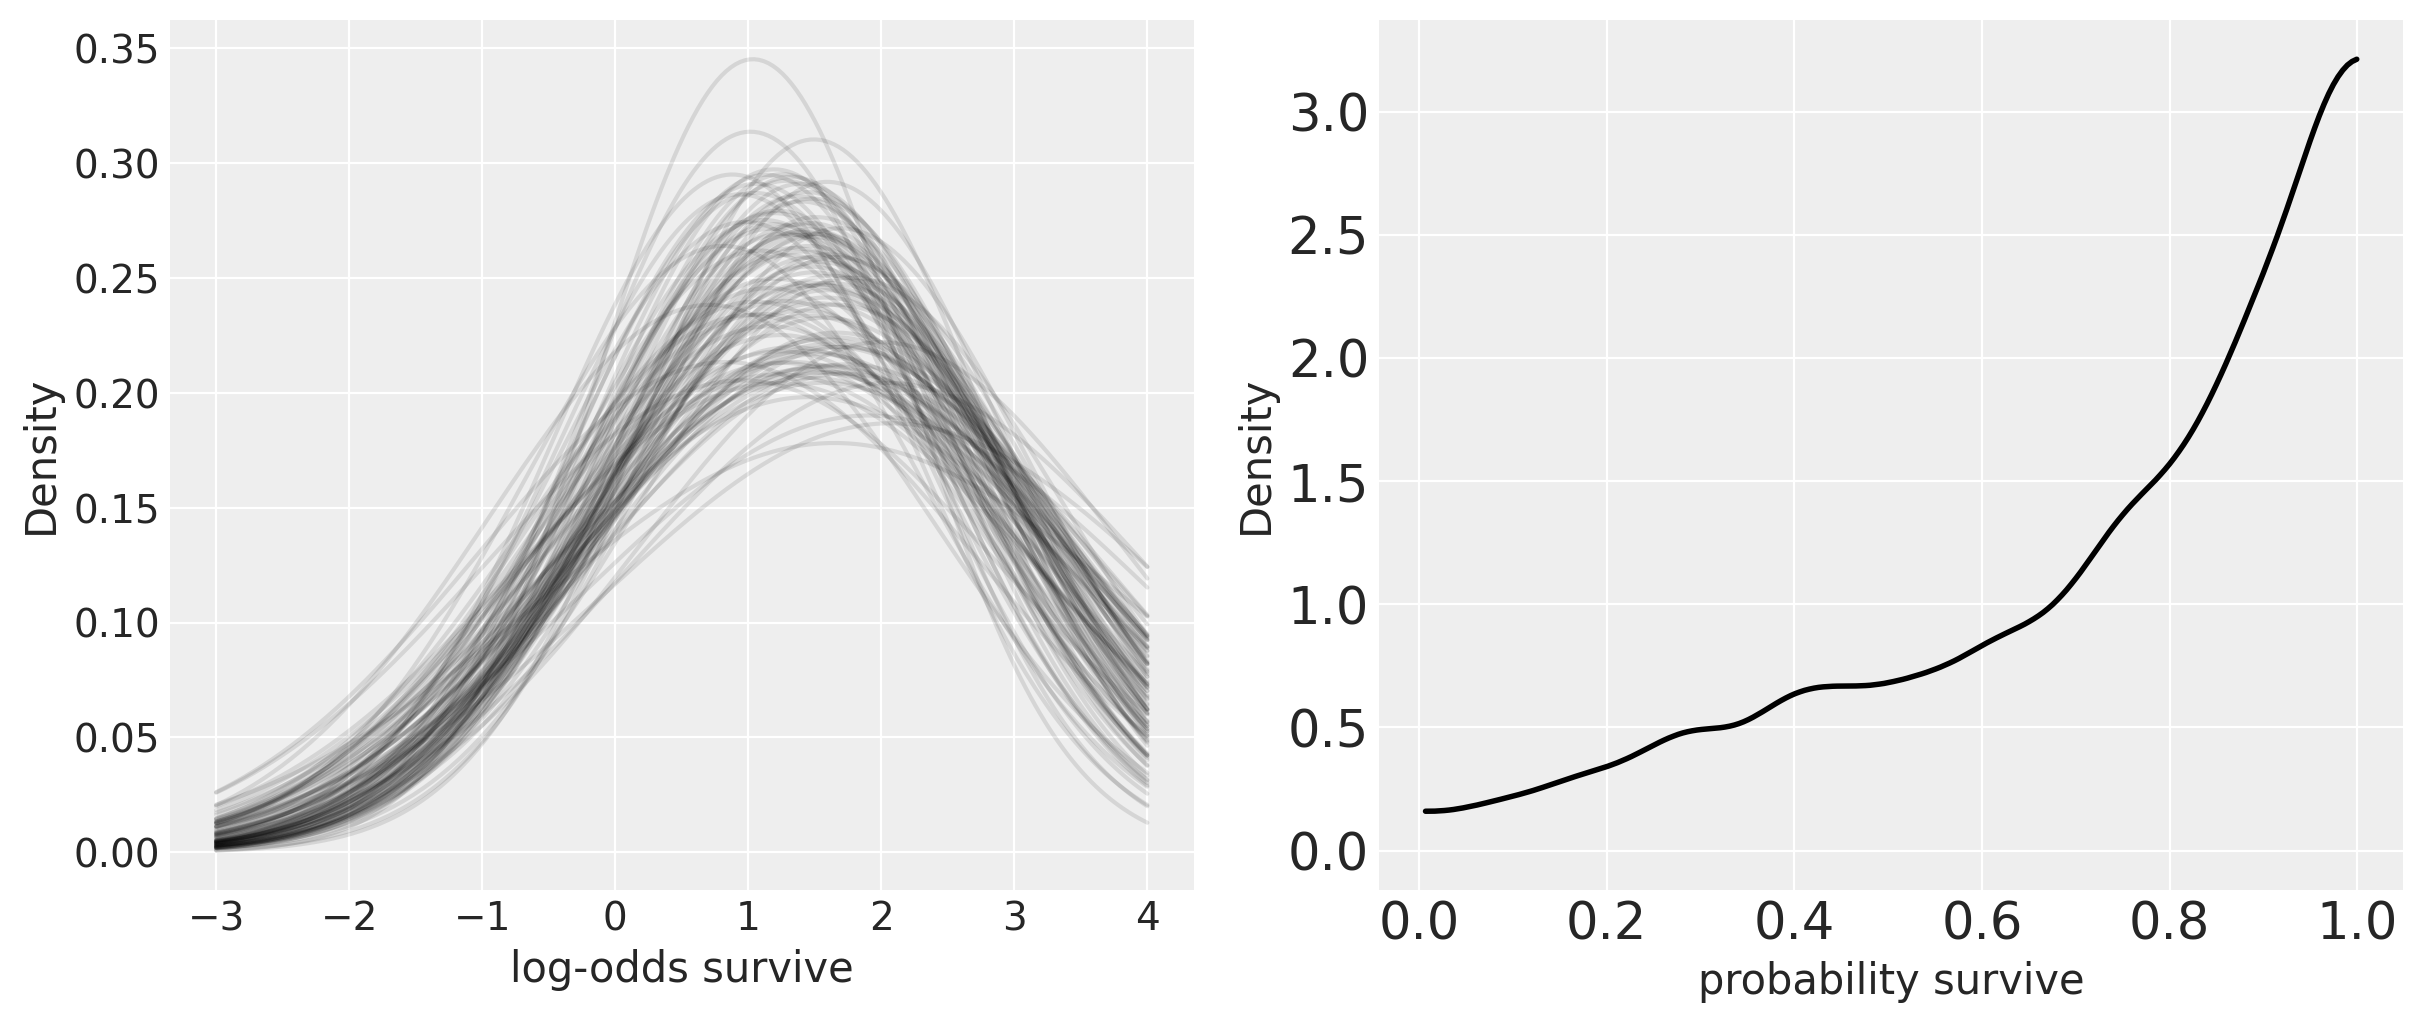

In [17]:
_, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# show first 100 populations in the posterior
xrange = np.linspace(-3, 4, 200)
postcurve = [
    stats.norm.pdf(xrange, loc=trace_m13_2['a_bar'][i], scale=trace_m13_2['sigma'][i])
    for i in range(100)
]
ax[0].plot(xrange, np.asarray(postcurve).T, alpha=0.1, color='k')
ax[0].set_xlabel("log-odds survive")
ax[0].set_ylabel("Density")

# sample 8000 imaginary tanks from the posterior distribution
sim_tanks = np.random.normal(loc=trace_m13_2['a_bar'], scale=trace_m13_2['sigma'])

# transform to probability and visualize
az.plot_kde(logistic(sim_tanks), ax=ax[1], plot_kwargs={"color": "k"})
ax[1].set_xlabel("probability survive")
ax[1].set_ylabel("Density");

To improve such a model, instead of using exponential priors for the variance components, you can use half-Normal priors or some other prior with a thin tail. A **half-Normal** is a Normal distribution with all mass above zero. It is just cut off below zero.

## 13.2. Varying effects and the underfitting/overfitting trade-off

Varying intercepts are just regularized estimates, but adaptively regularized by estimating how diverse the clusters are while estimating the features of each cluster. The reason that the varying intercepts provide better estimates is that they do a better job of trading off underfitting and overfitting.

To understand this in the context of the reed frog example, suppose that instead of experimental tanks we had natural ponds, so that we might be concerned with making predictions for the same clusters in the future. 

We’ll approach the problem of predicting future survival in these ponds, from three perspectives:
1. Complete pooling. This means we assume that the population of ponds is invariant, the same as estimating a common intercept for all ponds.

As a result, the total sample mean underfits the data. This is the **complete pooling** approach, pooling the data from all ponds to produce a single estimate that is applied to every pond.  This sort of model is equivalent to assuming that the variation among ponds is zero—all ponds are identical.

2. No pooling. This means we assume that each pond tells us nothing about any other pond. This is the model with amnesia.

This means using a separate intercept for each pond. As a consequence, the error of these estimates is high, and they are rather overfit to the data. These are sometimes called the **no pooling** estimates. No information is shared across ponds. It’s like assuming that the variation among ponds is infinite, so nothing you learn from one pond helps you predict another.


3. Partial pooling. This means using an adaptive regularizing prior, as in the previous section.

When you estimate varying intercepts, you use partial pooling of information to produce estimates for each cluster that are less underfit than the grand mean and less overfit than the no-pooling estimates. As a consequence, they tend to be better estimates of the true per-cluster (per-pond) means.



### 13.2.1. The model

$S_i \sim Binomial(N_i, p_i)$

$ logit(p_i) = \alpha_{pond[i]}$

$\alpha_j \sim Normal(\bar\alpha,\sigma)$

$\bar\alpha \sim Normal(0, 1.5)$

$\sigma \sim Exponential(1)$

$\bar\alpha$, the average log-odds of survival in the entire population of ponds

$\sigma$, the standard deviation of the distribution of log-odds of survival among ponds 

$\alpha$, a vector of individual pond intercepts, one for each pond
 

### 13.2.2. Assign values to the parameters

### Code 13.7

In [18]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat([5, 10, 25, 35], 15)

### Code 13.8

In [19]:
np.random.seed(42) 
a_pond = np.random.normal(loc=a_bar, scale=sigma, size=nponds)

### Code 13.9

In [20]:
dsim = pd.DataFrame(dict(pond=np.arange(nponds), Ni=Ni, true_a=a_pond))
dsim.head()

,pond,Ni,true_a
0,0,5,2.245071
1,1,5,1.292604
2,2,5,2.471533
3,3,5,3.784545
4,4,5,1.148770


### 13.2.3. Simulate survivors

### Code 3.11

In [21]:
dsim['Si'] = np.random.binomial(dsim['Ni'], logistic(dsim['true_a']))
dsim.head()

,pond,Ni,true_a,Si
0,0,5,2.245071,5
1,1,5,1.292604,5
2,2,5,2.471533,5
3,3,5,3.784545,5
4,4,5,1.148770,3


### 13.2.4. Compute the no-pooling estimates

### Code 13.12

In [22]:
dsim['p_nopool'] = dsim['Si'].values / dsim['Ni'].values
dsim.head()

,pond,Ni,true_a,Si,p_nopool
0,0,5,2.245071,5,1.0
1,1,5,1.292604,5,1.0
2,2,5,2.471533,5,1.0
3,3,5,3.784545,5,1.0
4,4,5,1.148770,3,0.6


### 13.2.5. Compute the partial-pooling estimates 

### Code 13.13

In [23]:
# define model: mortality ~ pond (multi-level)
with pm.Model() as m13_3:
    
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma = pm.Exponential('sigma', 1)
    
    a = pm.Normal('a', mu=a_bar, sd=sigma, shape=dsim['pond'].max()+1)
    
    pbar = pm.Deterministic('pbar', pm.math.invlogit(a[dsim['pond'].values]))
                      
    S = pm.Binomial('S', p=pbar, n=dsim['Ni'].values, observed=dsim['Si'].values)

    trace_m13_3 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2051.41draws/s]


### Code 13.14

In [24]:
# show model summary
varnames = ['~pbar']
az.summary(trace_m13_3, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a_bar,1.28,0.21,0.93,1.60
a[0],2.44,1.07,0.76,4.14
a[1],2.41,1.08,0.74,4.06
a[2],2.43,1.10,0.73,4.16
a[3],2.42,1.09,0.75,4.19
...,...,...,...,...
a[56],0.47,0.35,-0.13,0.99
a[57],0.47,0.34,-0.03,1.05
a[58],1.27,0.39,0.67,1.90
a[59],3.06,0.73,1.88,4.17


### Code 13.15

In [25]:
dsim['p_partpool'] = logistic(trace_m13_3['a']).mean(0)
dsim.head()

,pond,Ni,true_a,Si,p_nopool,p_partpool
0,0,5,2.245071,5,1.0,0.886973
1,1,5,1.292604,5,1.0,0.883854
2,2,5,2.471533,5,1.0,0.884532
3,3,5,3.784545,5,1.0,0.883657
4,4,5,1.148770,3,0.6,0.654339


### Code 13.16

In [26]:
dsim['p_true'] = logistic(dsim['true_a'])
dsim.head()

,pond,Ni,true_a,Si,p_nopool,p_partpool,p_true
0,0,5,2.245071,5,1.0,0.886973,0.904225
1,1,5,1.292604,5,1.0,0.883854,0.784588
2,2,5,2.471533,5,1.0,0.884532,0.922122
3,3,5,3.784545,5,1.0,0.883657,0.977785
4,4,5,1.148770,3,0.6,0.654339,0.759286


### Code 13.17

In [27]:
nopool_error = np.abs(dsim.p_nopool - dsim.p_true)
partpool_error = np.abs(dsim.p_partpool - dsim.p_true)

### Code 13.18 and Code 13.19

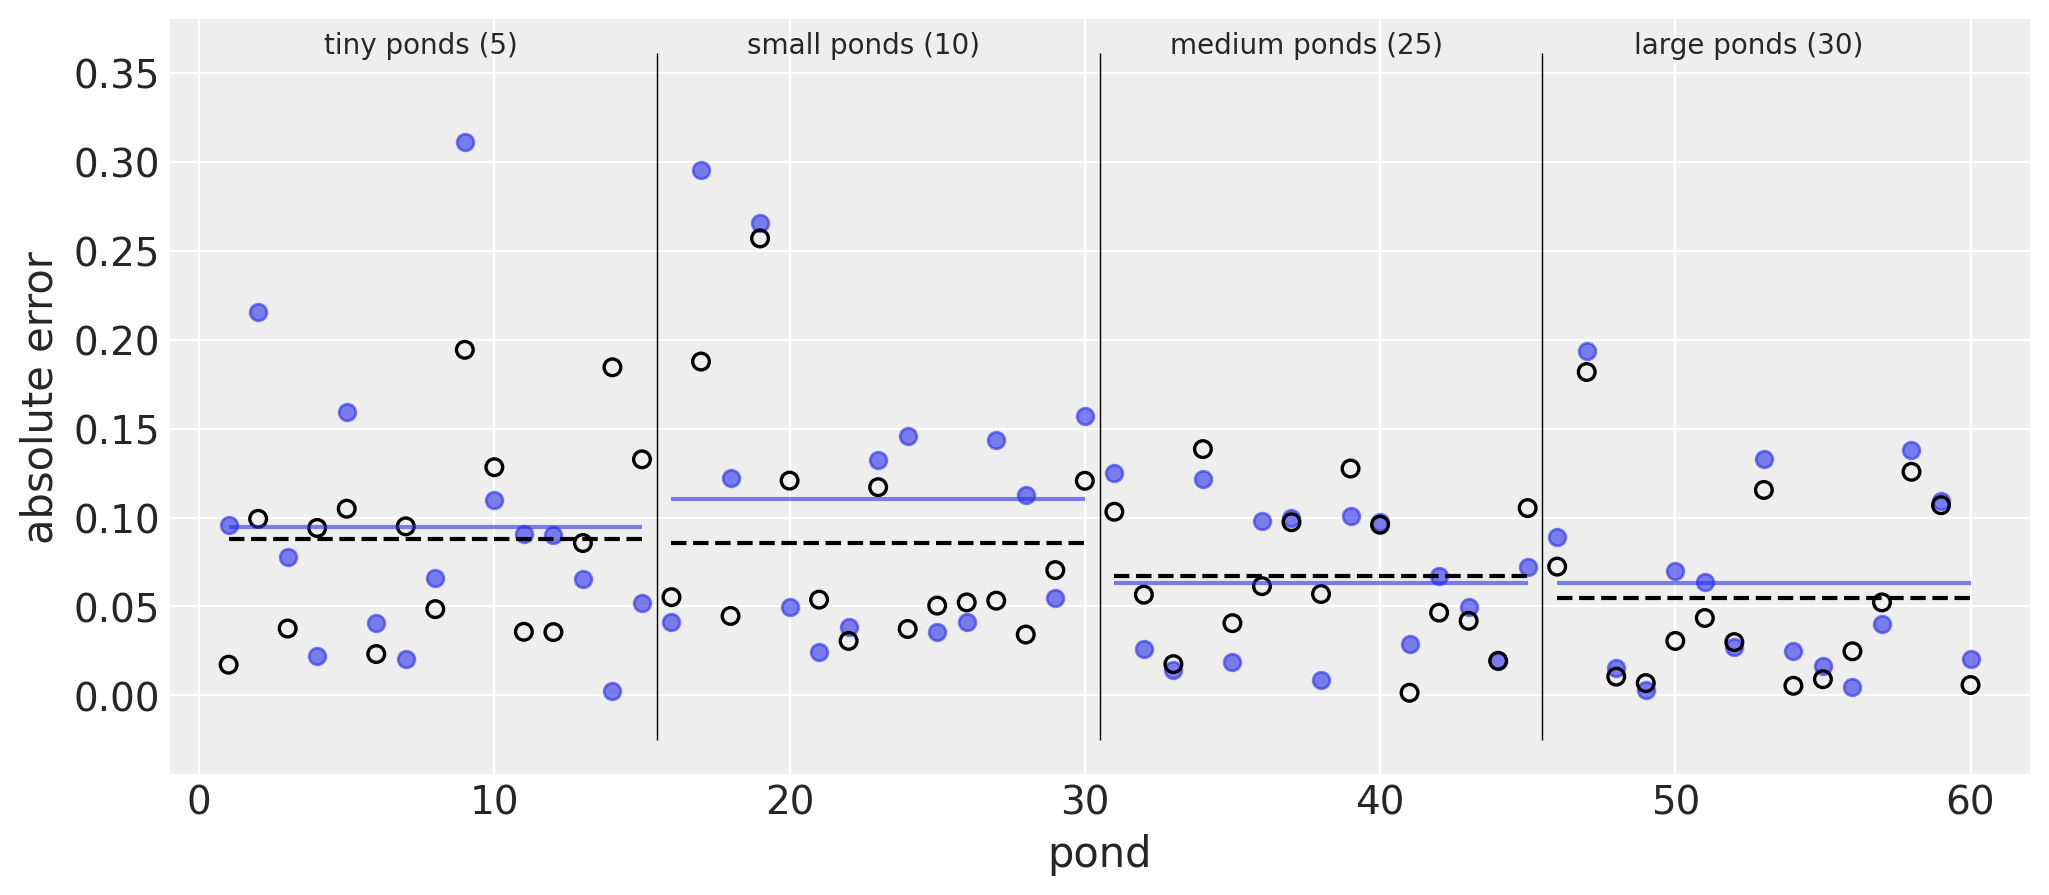

In [28]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
xrange = np.arange(60)
xrange_ = xrange.reshape((4, 15))

ax.scatter(xrange + 1, nopool_error, alpha=0.6)
ax.scatter(xrange + 1, partpool_error, facecolors="none", edgecolors="k", lw=1.2)
ax.vlines(xrange_[1:, 0] + 0.5, -0.025, max(nopool_error) + 0.05, lw=0.5)

textall = [
    "tiny ponds (5)",
    "small ponds (10)",
    "medium ponds (25)",
    "large ponds (30)",
]
for isem in range(4):
    ax.hlines(
        nopool_error[xrange_[isem, :]].mean(),
        xrange_[isem, 0] + 1,
        xrange_[isem, -1] + 1,
        color="C0",
        alpha=0.6,
    )
    ax.hlines(
        partpool_error[xrange_[isem, :]].mean(),
        xrange_[isem, 0] + 1,
        xrange_[isem, -1] + 1,
        color="k",
        linestyles="--",
    )
    ax.text(
        xrange_[isem, 7] + 0.5,
        max(nopool_error) + 0.05,
        textall[isem],
        horizontalalignment="center",
    )

ax.set_xlabel("pond")
ax.set_ylabel("absolute error")
ax.set_xlim(-1, 62);

### Code 13.20

This part is Stan related. To do the same in PyMC3 (i.e., avoid compiling the same model twice), you need to set up the input data with pm.Data. There are examples in this repository, and you can also take a look at this [tutorial](https://docs.pymc.io/notebooks/data_container.html).

## 13.3. More than one type of cluster

The kind of data structure in data(chimpanzees) is usually called a cross-classified multilevel model. It is cross-classified, because actors are not nested within unique blocks. If each chimpanzee had instead done all of his or her pulls on a single day, within a single block, then the data structure would instead be hierarchical. However, the model specification would typically be the same. 

### 13.3.1. Multilevel chimpanzees

### Code 13.21

In [29]:
df = pd.read_csv('Data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [30]:
df['treatment'] = df['prosoc_left'] + 2*df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,0
1,1,NaN,0,1,4,0,0,1,0
2,1,NaN,0,1,6,1,0,0,1
3,1,NaN,0,1,8,0,1,0,0
4,1,NaN,0,1,10,1,1,1,1


In [31]:
# change "actor" & "block" to zero-index
df['actor'] = df['actor'] - 1
df['block'] = df['block'] - 1

In [32]:
# define model: pulled_left ~ actor + treatment
with pm.Model() as m13_4:   
    
    # hyper-priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    sigma_g = pm.Exponential('sigma_g', 1)
    
    # adaptive priors
    a = pm.Normal('a', mu=a_bar, sd=sigma_a, shape=df['actor'].max()+1)
    g = pm.Normal('g', mu=0, sd=sigma_g, shape=df['block'].max()+1)
    
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['treatment'].max()+1)
    
    p = pm.Deterministic('p', pm.math.invlogit(a[df['actor'].values] 
                                               + b[df['treatment'].values]
                                               + g[df['block'].values]))
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    
    trace_m13_4 = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, g, a, sigma_g, sigma_a, a_bar]
Sampling 4 chains, 5 divergences: 100%|██████████| 14000/14000 [00:35<00:00, 393.25draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8679554461229836, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### Code 13.22

In [33]:
# show model summary
varnames = ['~p']
az.summary(trace_m13_4, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a_bar,0.58,0.71,-0.71,1.55
a[0],-0.38,0.36,-0.94,0.21
a[1],4.66,1.34,2.82,6.51
a[2],-0.68,0.35,-1.21,-0.12
a[3],-0.68,0.35,-1.23,-0.13
a[4],-0.38,0.36,-0.93,0.21
a[5],0.57,0.36,-0.01,1.13
a[6],2.10,0.46,1.32,2.77
g[0],-0.15,0.21,-0.48,0.10
g[1],0.04,0.18,-0.22,0.30


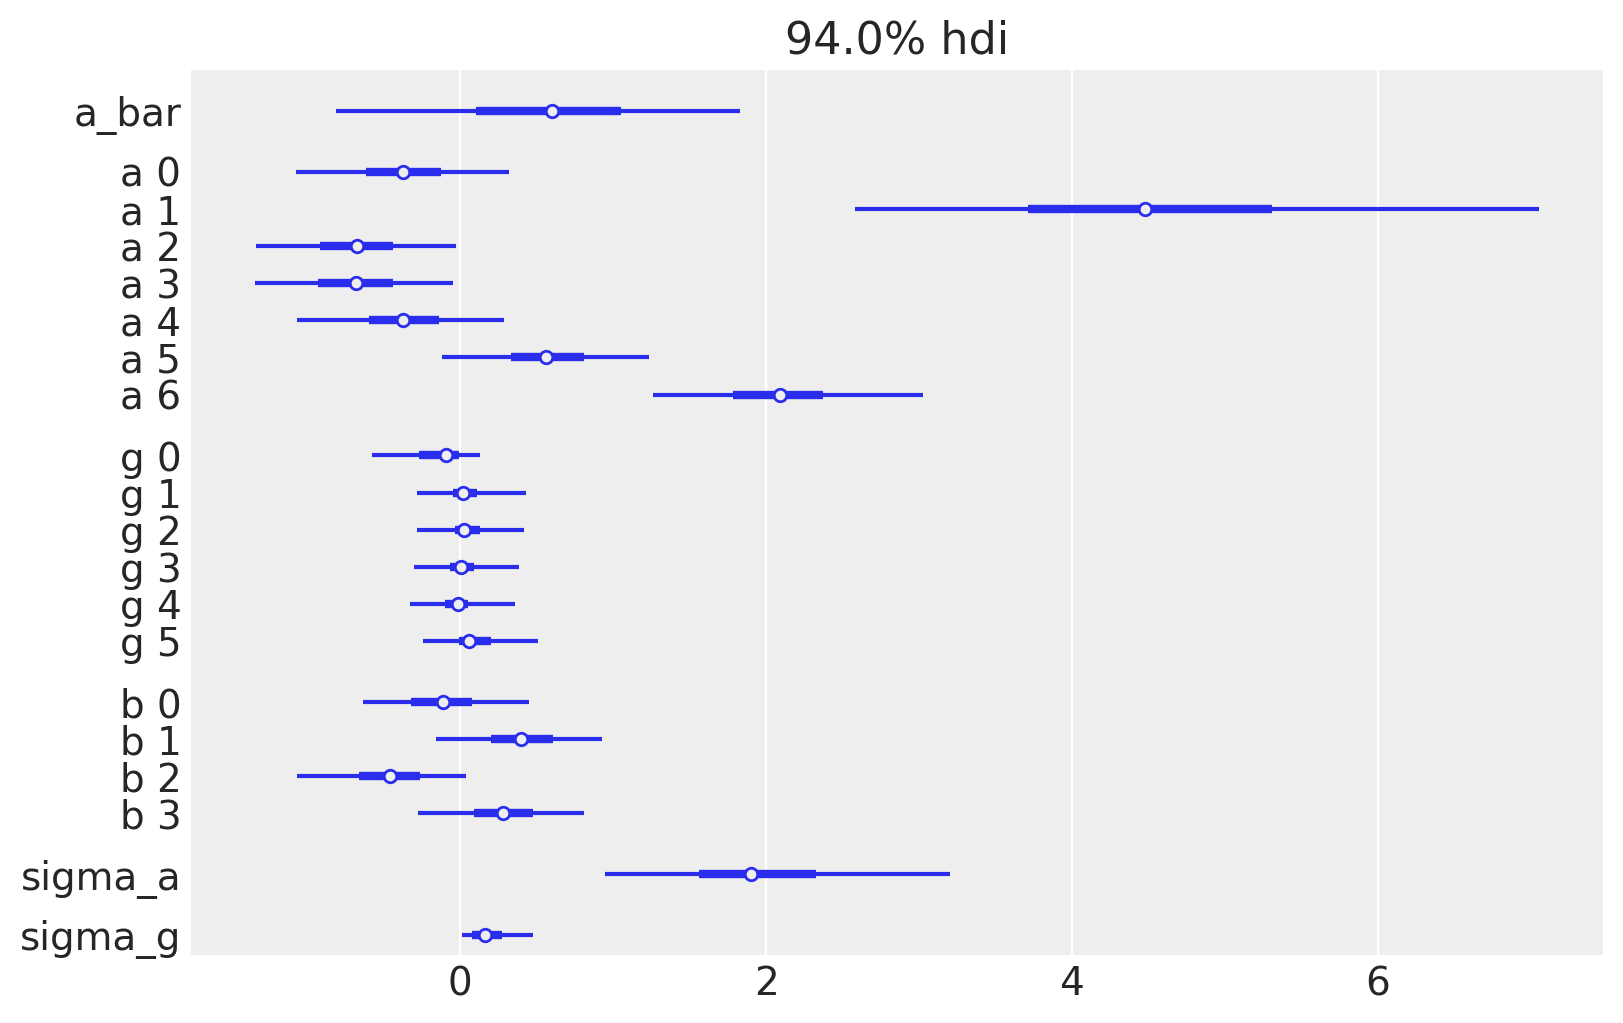

In [34]:
az.plot_forest(
    trace_m13_4,
    kind='forestplot',
    var_names=['~p'],
    combined=True,
    ridgeplot_overlap=3,
    hdi_prob=0.94,
    figsize=(8, 5))
plt.show()

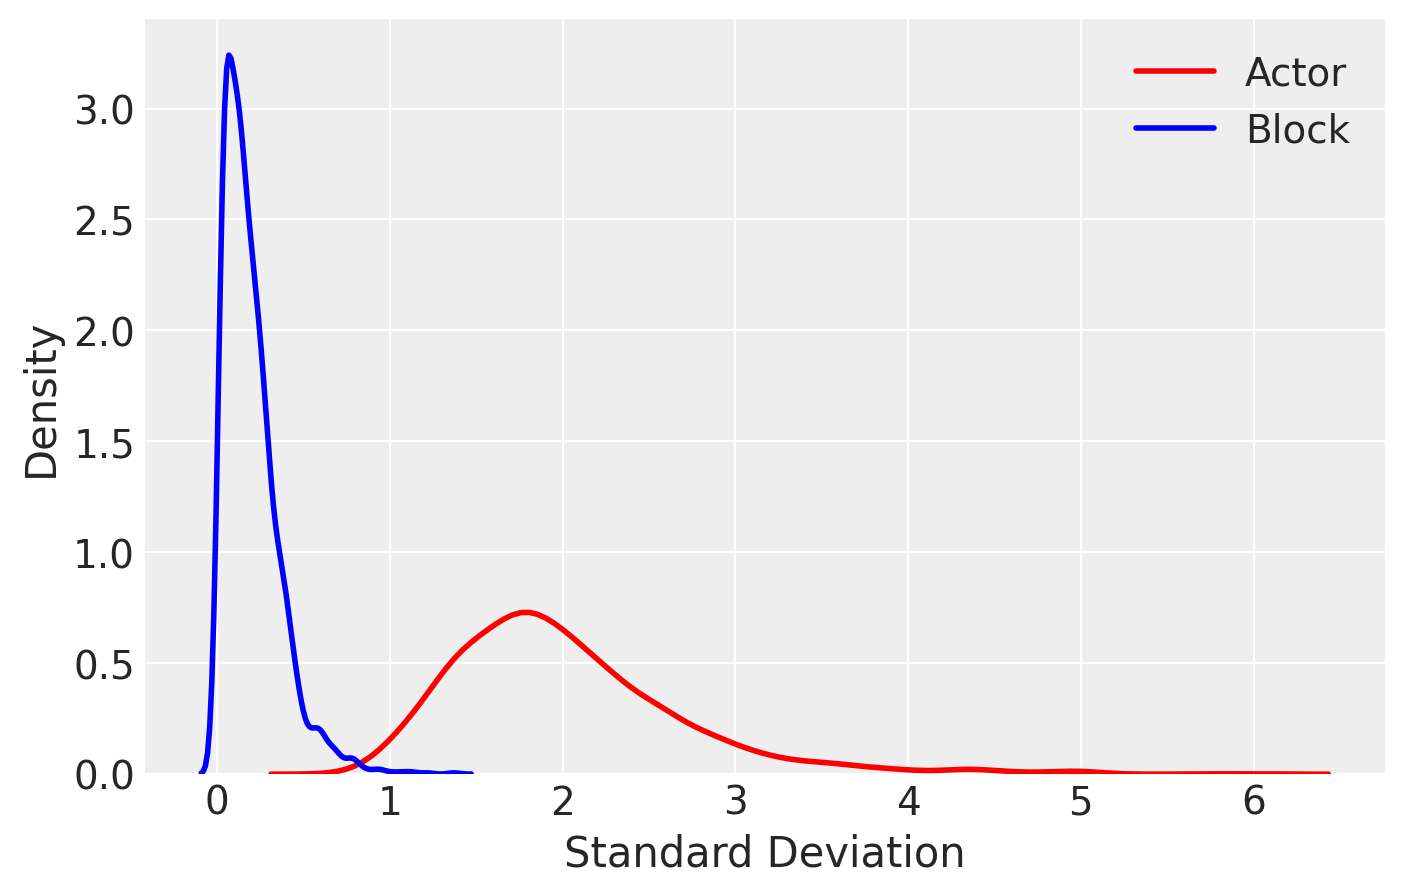

In [35]:
# plot figure
fig = plt.figure(figsize=(8, 5))
sns.distplot(trace_m13_4['sigma_a'], hist = False, kde = True, kde_kws = {'linewidth': 2, 'color': 'r'}, label="Actor")
sns.distplot(trace_m13_4['sigma_g'], hist = False, kde = True, kde_kws = {'linewidth': 2, 'color': 'b'}, label="Block")
plt.xlabel('Standard Deviation', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

### Code 13.23

In [36]:
# define model: pulled_left ~ actor + block + treatment (partial pooling on the treatments)
with pm.Model() as m13_5:   
    
    # hyper-priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    
    # adaptive priors
    a = pm.Normal('a', mu=a_bar, sd=sigma_a, shape=df['actor'].max()+1)
    
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['treatment'].max()+1)
    
    p = pm.Deterministic('p', pm.math.invlogit(a[df['actor'].values] 
                                               + b[df['treatment'].values]))
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    
    trace_m13_5 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_a, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1480.46draws/s]


### Code 13.24

In [37]:
# model compare
pm.compare({'m13_4': trace_m13_4,
            'm13_5': trace_m13_5}, ic='WAIC', scale='deviance')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13_5,0,530.982,8.44086,0,0.623316,19.5654,0,False,deviance
m13_4,1,532.162,10.467,1.17954,0.376684,19.3343,1.58707,False,deviance


 pWAIC column, which reports the “effective number of parameters.”

### 13.3.2. Even more clusters

### Code 13.25

In [38]:
# define model: pulled_left ~ actor + block + treatment
with pm.Model() as m13_6:   
    
    # hyper-priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    sigma_g = pm.Exponential('sigma_g', 1)
    sigma_b = pm.Exponential('sigma_b', 1)
    
    # adaptive priors
    a = pm.Normal('a', mu=a_bar, sd=sigma_a, shape=df['actor'].max()+1)
    b = pm.Normal('b', mu=0, sd=sigma_b, shape=df['treatment'].max()+1)
    g = pm.Normal('g', mu=0, sd=sigma_g, shape=df['block'].max()+1)
      
    p = pm.Deterministic('p', pm.math.invlogit(a[df['actor'].values] 
                                               + b[df['treatment'].values]
                                               + g[df['block'].values]))
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    
    trace_m13_6 = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a, sigma_b, sigma_g, sigma_a, a_bar]
Sampling 4 chains, 2 divergences: 100%|██████████| 14000/14000 [01:02<00:00, 225.55draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [39]:
# show model summary
varnames = ['b']
m13_6 = az.summary(trace_m13_6, varnames, kind='stats', round_to=2, hdi_prob=0.89)["mean"]
m13_6.name = "m13_6"
m13_4 = az.summary(trace_m13_4, varnames, kind='stats', round_to=2, hdi_prob=0.89)["mean"]
m13_4.name = "m13_4"
pd.concat([m13_4, m13_6], axis=1)

,m13_4,m13_6
b[0],-0.12,-0.13
b[1],0.40,0.37
b[2],-0.46,-0.45
b[3],0.27,0.26


## 13.4. Divergent transition sand non-centered priors

When you work with multilevel models, divergent transitions are commonplace.

Sometimes the total energy is not the same at the end as it was at the start. In these cases, the energy is divergent. How can this happen? It tends to happen when the posterior distribution is very steep in some region of parameter space. Steep changes in probability are hard for a discrete physics simulation to follow. When that happens, the algorithm notices by comparing the energy at the start to the energy at the end. When they don’t match, it indicates numerical problems exploring that part of the posterior distribution.

1.  The first is to tune the simulation so that it doesn’t overshoot the valley wall. But for many models, you can never tune the sampler enough to remove the divergent transitions. 

2. The second trick is to write the statistical model in a new way, to reparameterize it. 

### 13.4.1. The Devil’s Funnel

### Code 13.26

In [40]:
# define model
with pm.Model() as m13_7:   
    
    v = pm.Normal('v', mu=0, sd=3)
    x = pm.Normal('x', mu=0, sd=pm.math.exp(v))
    
    trace_m13_7 = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, v]
Sampling 4 chains, 215 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1335.52draws/s]
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5526263915558395, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5628143353063089, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5963883432578779, but should be close to 0.8. Try to increase the number 

In [41]:
az.summary(trace_m13_7, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
v,3.40,1.62,0.63,5.57
x,24.41,219.20,-167.60,191.12


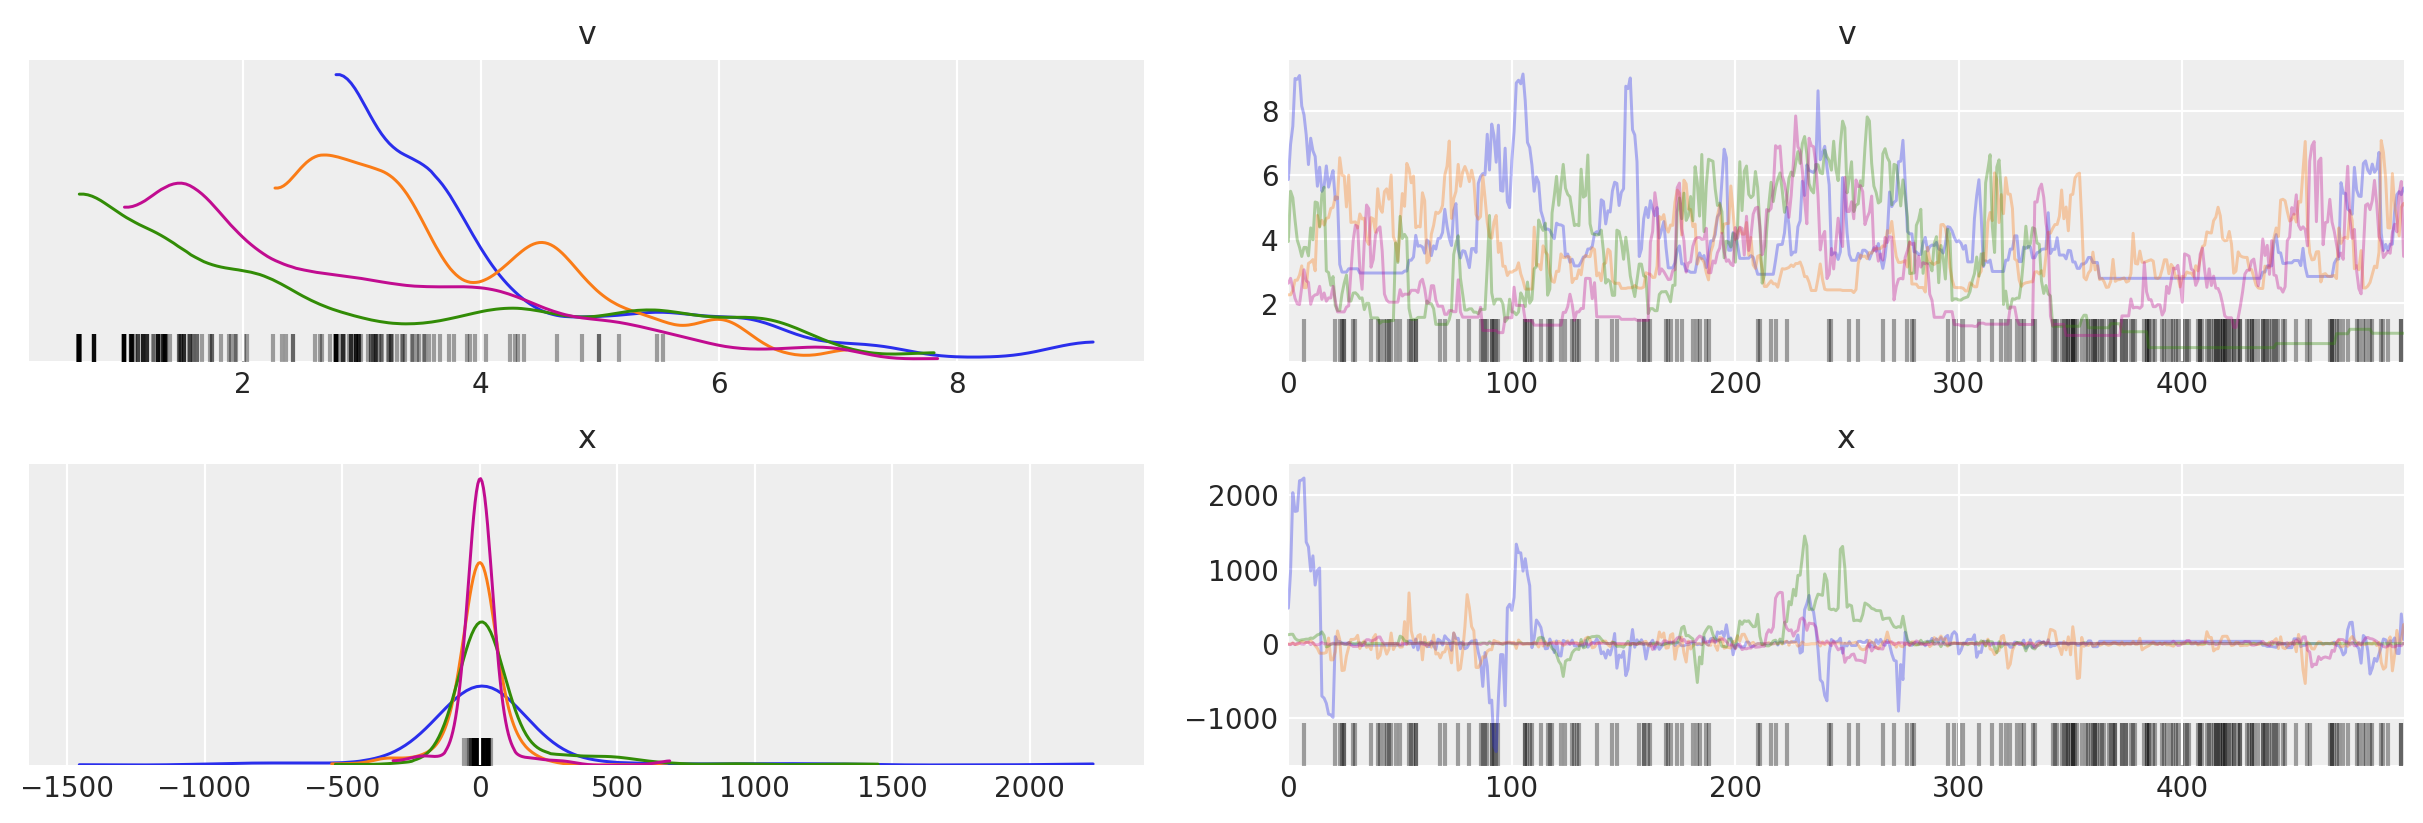

In [42]:
az.plot_trace(trace_m13_7);


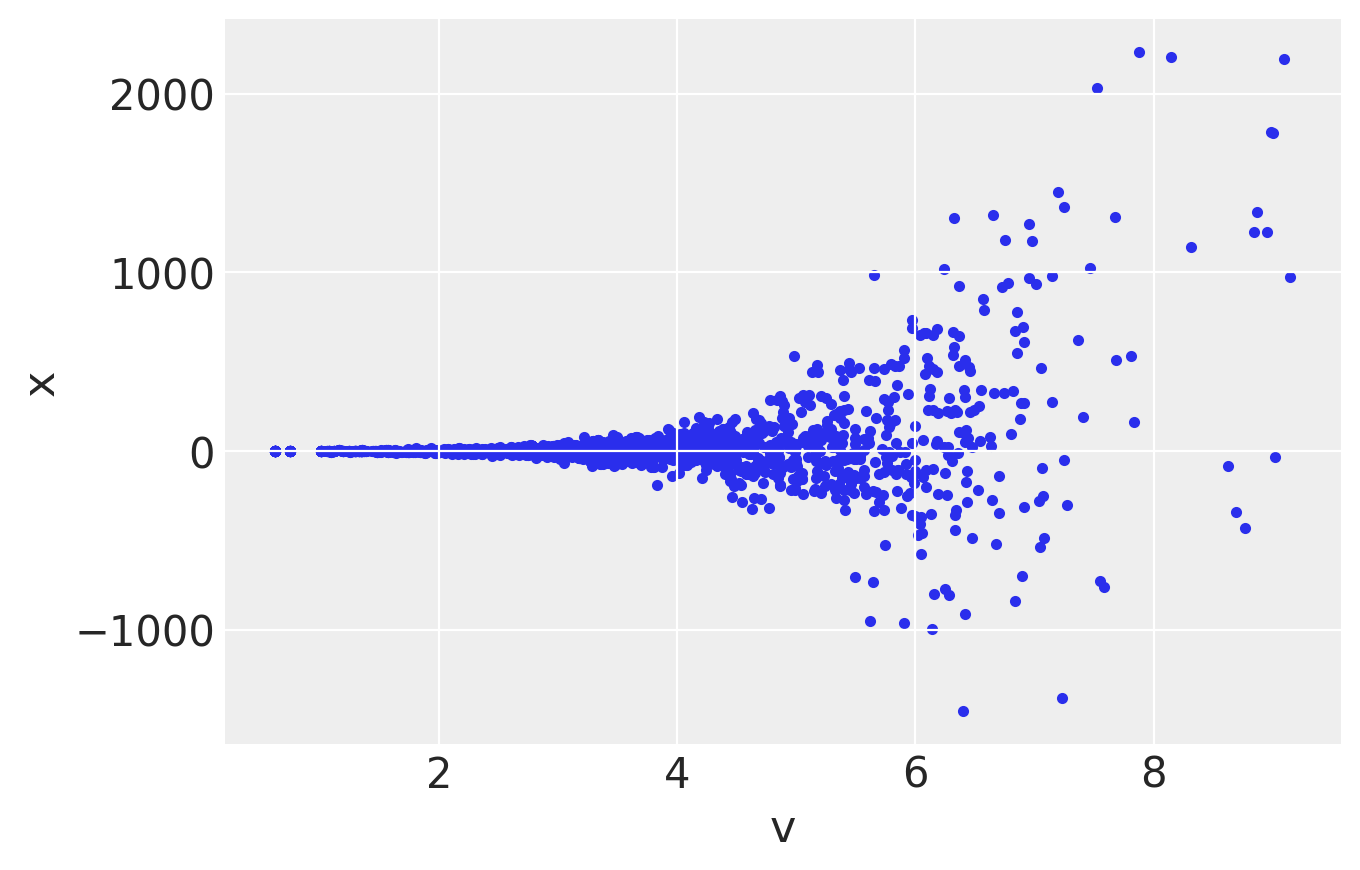

In [43]:
az.plot_pair(trace_m13_7, textsize=15);


$x \sim Normal(0,exp(v))$

This is the source of the funnel: As $v$ changes, the distribution of $x$ changes in a very inconvenient way. This parameterization is known as the **centered parameterization**. This is not a very intuitive name. It just indicates that the distribution of x is conditional on one or more other parameters.

The alternative is a **non-centered** parameterization. A non-centered parameterization moves the embedded parameter, $v$ in this case, out of the definition of the other parameter. For The Devil’s Funnel, we can accomplish that like this

$v \sim Normal(0,3)$

$z \sim Normal(0,1)$

$x = z \times exp(v)$

The result is that x in the non-centered version has the same distribution as x in the original, centered version. 

### Code 13.27

In [44]:
# define model
with pm.Model() as m13_7nc:   
    
    v = pm.Normal('v', mu=0, sd=3)
    z = pm.Normal('z', mu=0, sd=1)
    x = pm.Deterministic('x', z*pm.math.exp(v))
    
    trace_m13_7nc = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, v]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 4220.58draws/s]


In [45]:
az.summary(trace_m13_7nc, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
v,0.08,3.18,-4.66,5.22
z,-0.00,1.03,-1.56,1.66
x,8.62,719.39,-43.76,30.42


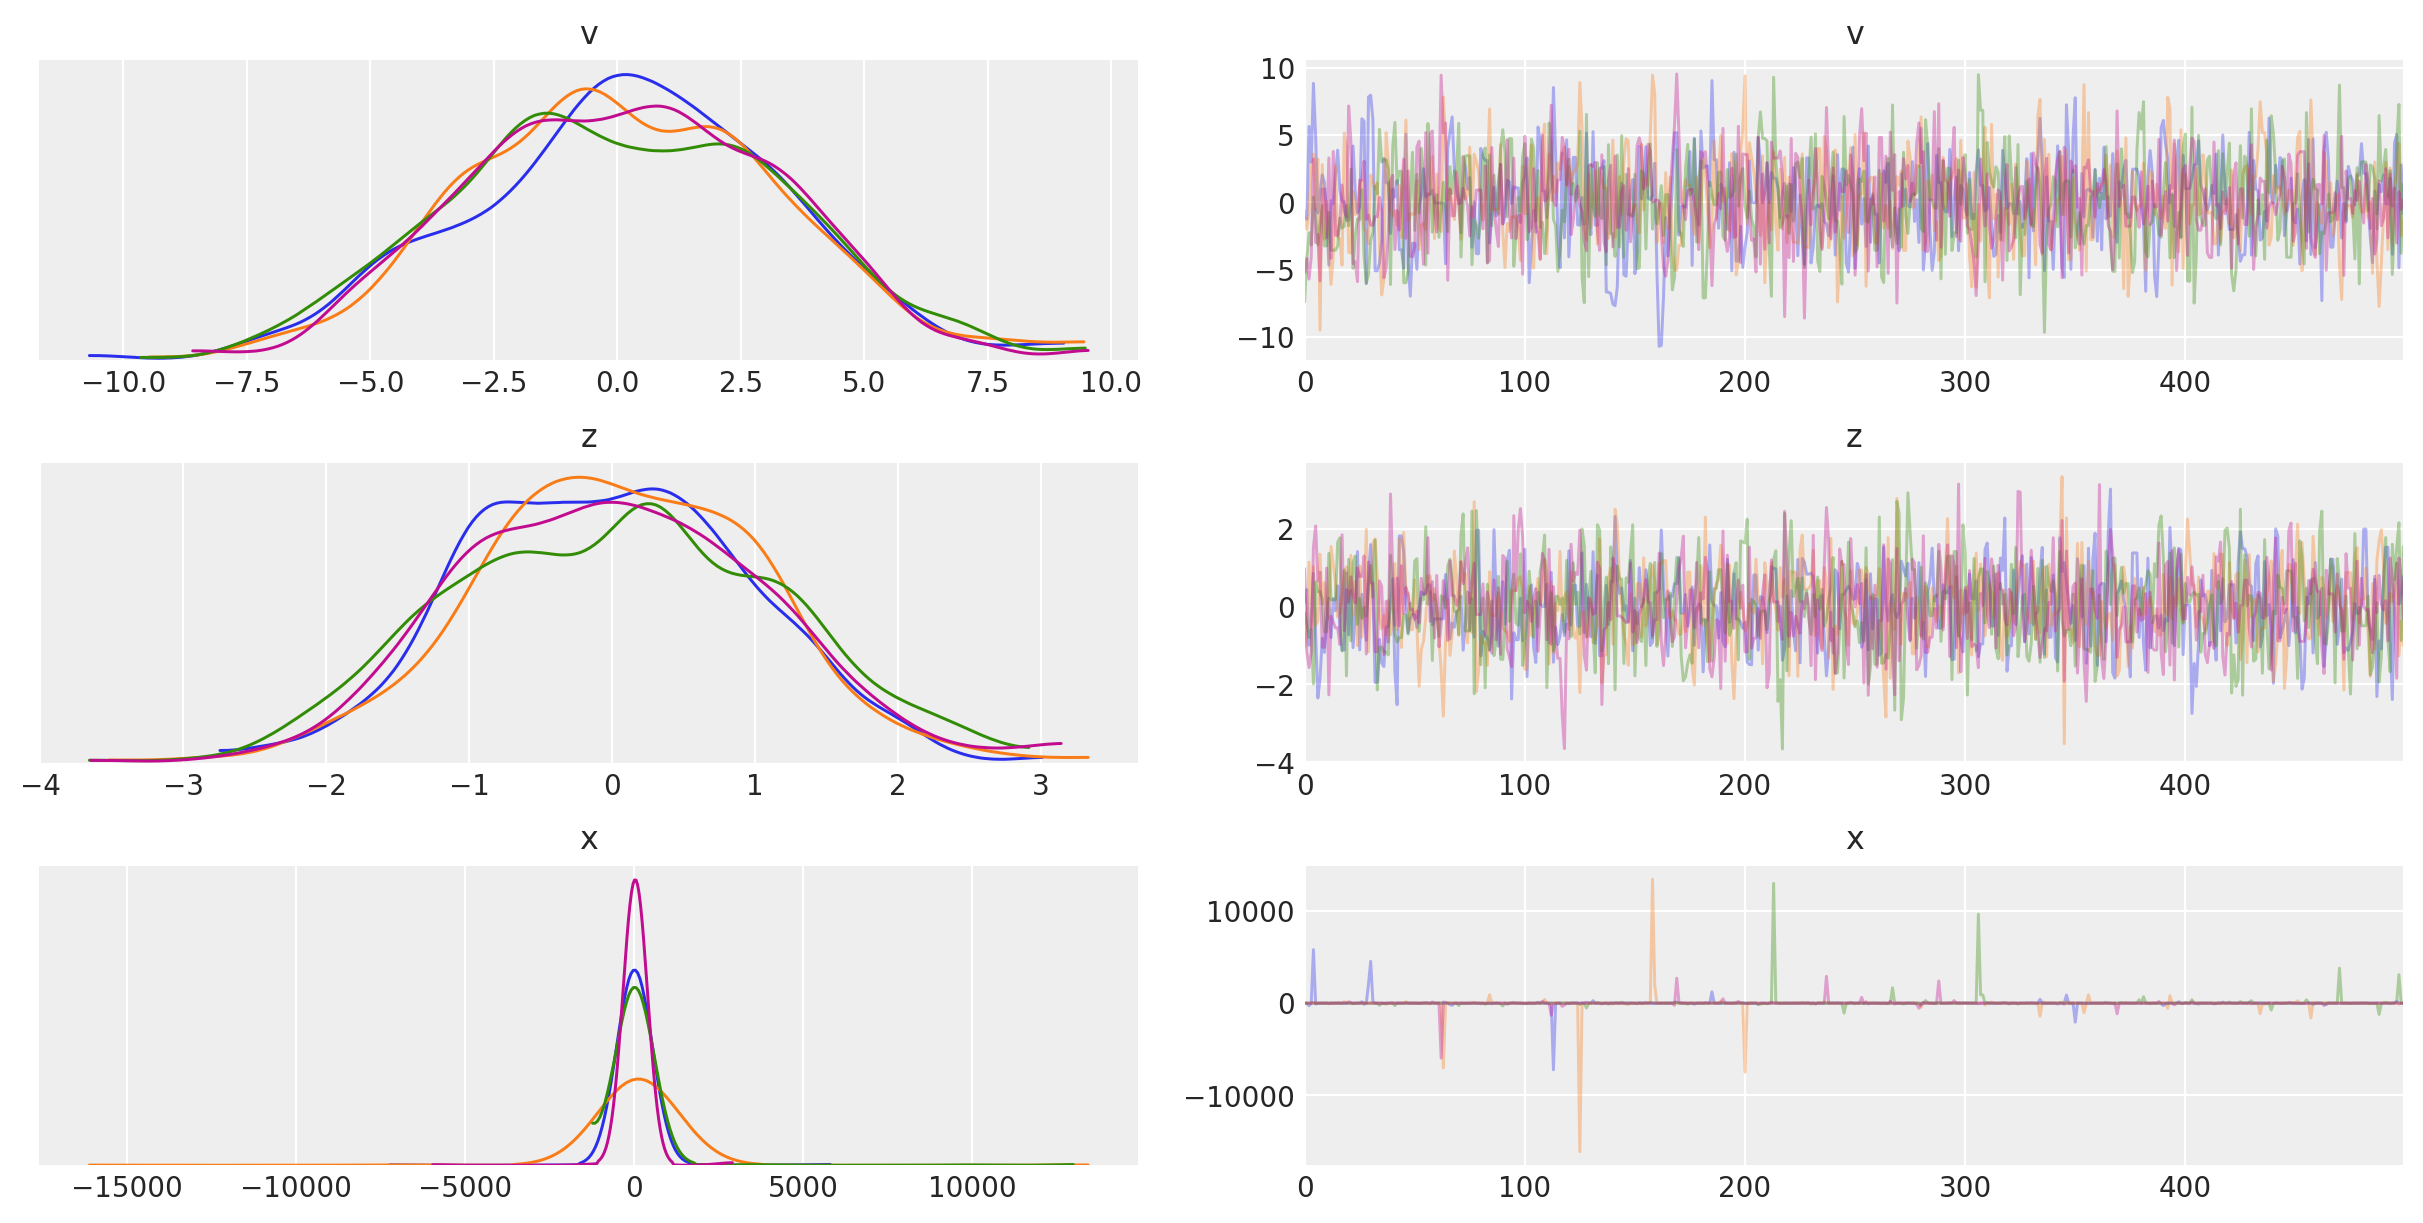

In [46]:
az.plot_trace(trace_m13_7nc);

If you plot $x$ against $v$, you will see the funnel. We managed to sample it by sampling a different variable and then transforming it. That is the non-centered parameterization. It’s used all the time when working with multilevel models.

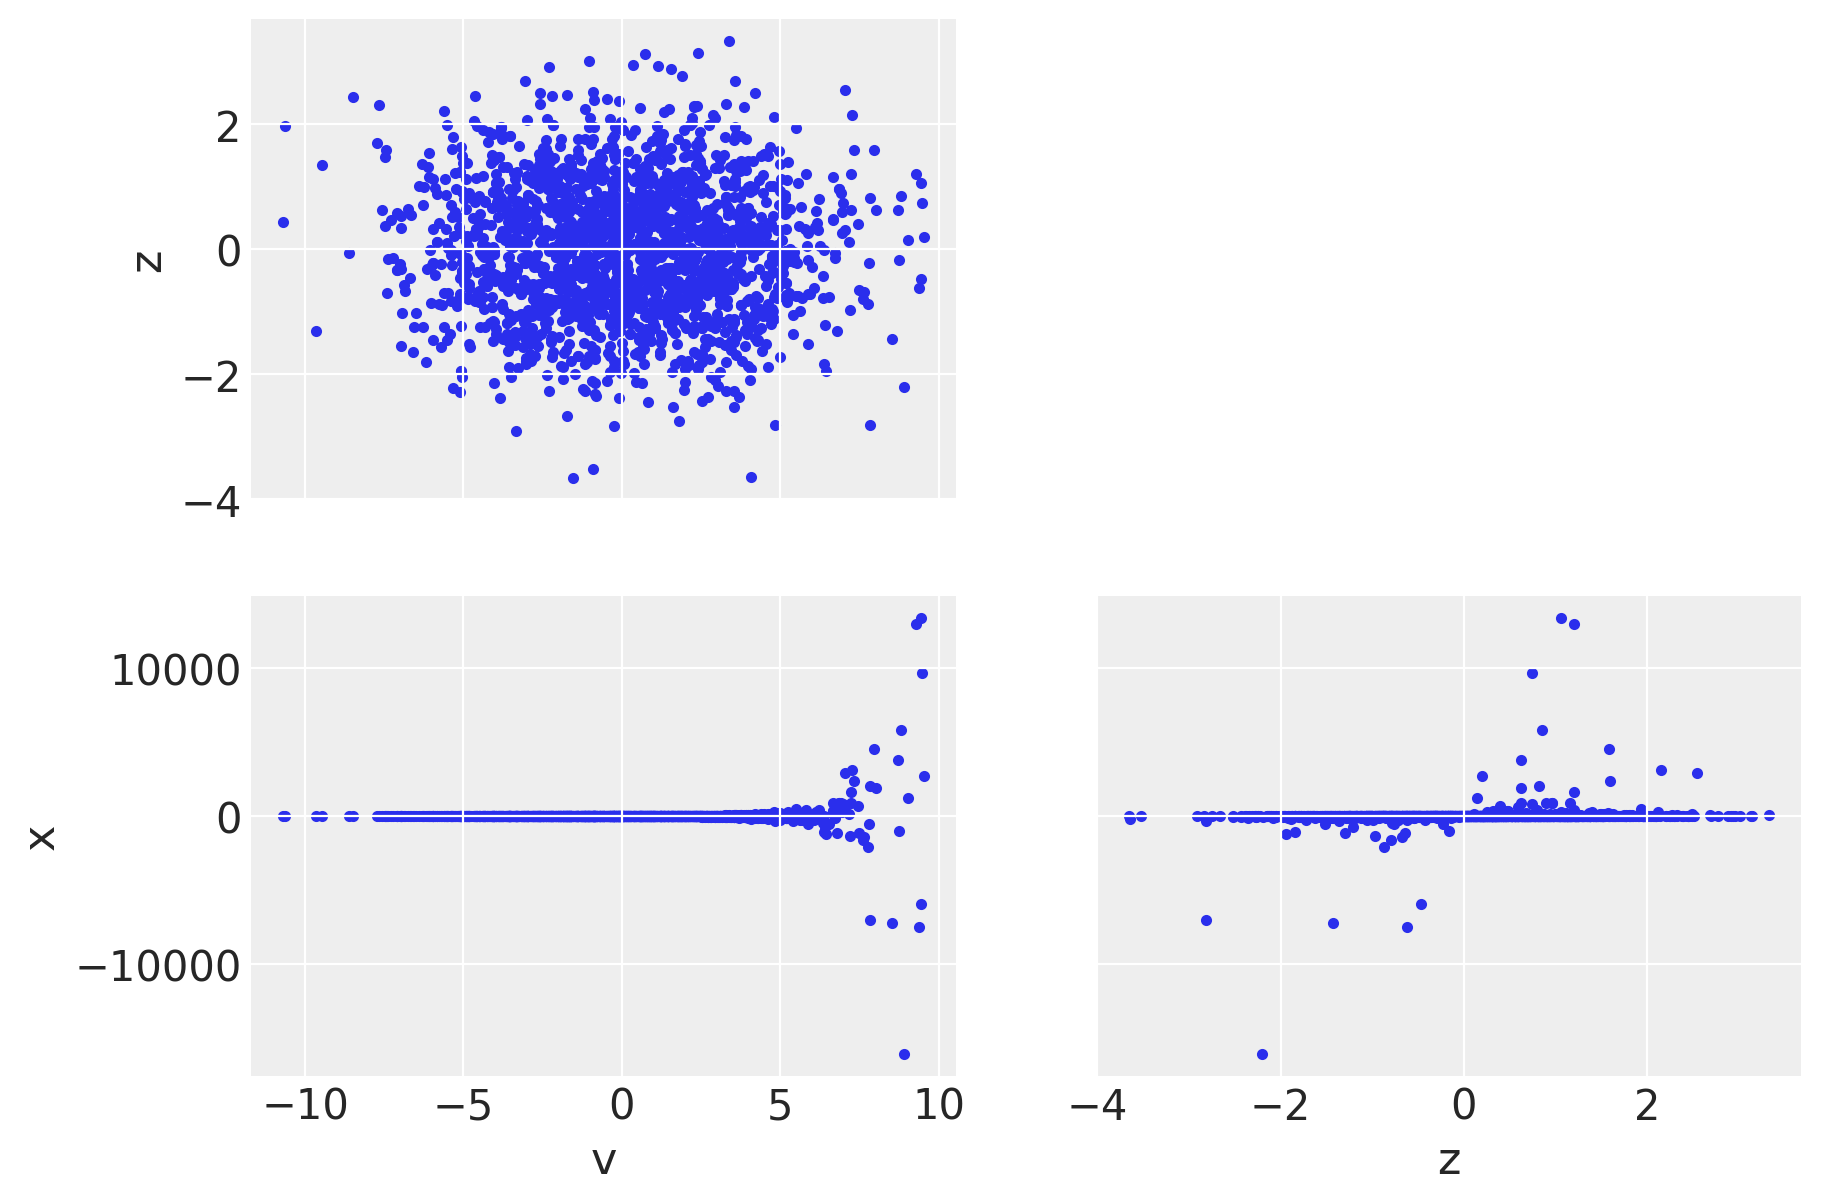

In [47]:
az.plot_pair(trace_m13_7nc, textsize=15, figsize=(10, 7));


### 13.4.2. Non-centered chimpanzees

### Code 13.28

In [48]:
# define model: pulled_left ~ actor + treatment
with pm.Model() as m13_4:   
    
    # hyper-priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    sigma_g = pm.Exponential('sigma_g', 1)
    
    # adaptive priors
    a = pm.Normal('a', mu=a_bar, sd=sigma_a, shape=df['actor'].max()+1)
    g = pm.Normal('g', mu=0, sd=sigma_g, shape=df['block'].max()+1)
    
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['treatment'].max()+1)
    
    p = pm.Deterministic('p', pm.math.invlogit(a[df['actor'].values] 
                                               + b[df['treatment'].values]
                                               + g[df['block'].values]))
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    
    trace_m13_4 = pm.sample(tune=3000, target_accept=0.99, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, g, a, sigma_g, sigma_a, a_bar]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [03:10<00:00, 73.56draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [49]:
# show model summary
varnames = ['~p']
az.summary(trace_m13_4, varnames, kind='stats', round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a_bar,0.60,0.72,-0.48,1.77
a[0],-0.36,0.36,-0.93,0.22
a[1],4.71,1.24,2.72,6.49
a[2],-0.67,0.36,-1.21,-0.08
a[3],-0.66,0.36,-1.26,-0.13
a[4],-0.36,0.36,-0.91,0.23
a[5],0.58,0.35,0.01,1.11
a[6],2.10,0.44,1.33,2.75
g[0],-0.17,0.21,-0.52,0.08
g[1],0.04,0.18,-0.22,0.34


### Code 13.29

In [50]:
# define model: pulled_left ~ actor + treatment
with pm.Model() as m13_4nc:   
    
    # hyper-priors
    a_bar = pm.Normal('a_bar', mu=0, sd=1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    sigma_g = pm.Exponential('sigma_g', 1)
    
    # adaptive priors
    x = pm.Normal('x', mu=0, sd=1, shape=df['block'].max()+1)
    z = pm.Normal('z', mu=0, sd=1, shape=df['actor'].max()+1)
    b = pm.Normal('b', mu=0, sd=0.5, shape=df['treatment'].max()+1)
    
    p = pm.Deterministic('p', pm.math.invlogit(a_bar+z[df['actor'].values]*sigma_a 
                                               +x[df['block'].values]*sigma_g
                                               +b[df['treatment'].values]))
    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=df['pulled_left'])
    
    trace_m13_4nc = pm.sample(tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, z, x, sigma_g, sigma_a, a_bar]
Sampling 4 chains, 1 divergences: 100%|██████████| 6000/6000 [00:29<00:00, 201.48draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [51]:
m13_4 = az.summary(trace_m13_4, var_names= ["~p"], kind="diagnostics", round_to=2)["ess_bulk"]
m13_4.name = "m13_4"

m13_4nc = az.summary(trace_m13_4nc, var_names=["~x", "~z", "~p"], kind="diagnostics", round_to=2)["ess_bulk"]
m13_4nc.name = "m13_4nc"

ess_bulk = pd.concat([m13_4, m13_4nc], axis=1, sort=True)

In [52]:
ess_bulk

,m13_4,m13_4nc
a[0],591.81,NaN
a[1],1342.36,NaN
a[2],637.35,NaN
a[3],547.71,NaN
a[4],621.25,NaN
a[5],599.42,NaN
a[6],921.59,NaN
a_bar,1019.73,739.50
b[0],574.25,1414.93
b[1],552.24,1545.08


So should we always use the non-centered parameterization? No. Sometimes the centered form is better.  It could even be true that the centered form is better for one cluster in a model while the non-centered form is better for another cluster in the same model. 

## 13.5. Multilevel posterior predictions

###  Referece


[pymc-devs: Rethinking_2 Chp13](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_13.ipynb)